In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tsai.all import *
import sklearn.preprocessing as pp
import scipy as sp
import scipy.spatial.distance as distance
from sklearn.preprocessing import StandardScaler
from utils import *
from scipy.stats import norm, multivariate_normal, chi2

## Estimate piors' PDFs and Visualize

In [9]:
def fit_gaussian(data):
    """
    Fit a multivariate Gaussian to the data.
    
    Parameters:
    data (array-like): 2D array of shape (n_samples, n_features).
    
    Returns:
    tuple: Mean vector and covariance matrix of the Gaussian.
    """
    mean = np.mean(data, axis=0)
    std_val = np.std(data)
    return mean, std_val


def plot_gaussian_1d_trimmed(data, mean, std_dev, color='red', title='1D Gaussian Fit'):
    """
    Plot a 1D Gaussian distribution on top of the data histogram after removing
    the lowest and highest 10% of the data (outliers).
    
    Parameters:
    data (array-like): The original data used to fit the Gaussian.
    mean (float): Mean of the Gaussian.
    std_dev (float): Standard deviation of the Gaussian.
    color (str): Color for the Gaussian curve.
    """
    # Calculate the 10th and 90th percentiles
    lower_bound = np.percentile(data, 2)
    upper_bound = np.percentile(data, 98)
    
    # Filter the data to remove the lowest and highest 10%
    trimmed_data = data[(data >= lower_bound) & (data <= upper_bound)]
    std_dev = np.std(trimmed_data)
    mean = np.mean(trimmed_data)
    # Create a range of x values for the Gaussian plot
    x = np.linspace(min(trimmed_data), max(trimmed_data), 1000)
    
    # Get the corresponding y values for the Gaussian PDF
    gaussian_pdf = norm.pdf(x, mean, std_dev)
    
    # Plot the trimmed data histogram
    plt.hist(trimmed_data, bins=30, density=True, alpha=0.6, color='blue')
    
    # Plot the Gaussian curve
    plt.plot(x, gaussian_pdf, color=color, lw=2)
    plt.title(title)
    plt.xlabel('Data')
    plt.ylabel('Probability Density')
    plt.show()

def plot_gaussian_1d(data, mean, std_dev, color='red', title='1D Gaussian Fit'):
    """
    Plot a 1D Gaussian distribution on top of the data histogram.
    
    Parameters:
    data (array-like): The original data used to fit the Gaussian.
    mean (float): Mean of the Gaussian.
    std_dev (float): Standard deviation of the Gaussian.
    color (str): Color for the Gaussian curve.
    """
    # Create a range of x values
    x = np.linspace(min(data), max(data), 1000)
    
    # Get the corresponding y values for the Gaussian PDF
    gaussian_pdf = norm.pdf(x, mean, std_dev)

    # Plot the data histogram
    plt.hist(data, bins=30, density=True, alpha=0.6, color='blue')
    
    # Plot the Gaussian curve
    plt.plot(x, gaussian_pdf, color=color, lw=2)
    plt.title(title)
    plt.xlabel('Data')
    plt.ylabel('Probability Density')
    plt.show()


def compute_mahalanobis_z_squared(sample, mean, cov):
    """
    Computes the Mahalanobis distance (equivalent to multivariate z score)
    for a given sample with respect to a multivariate normal distribution.

    Parameters:
    - sample: The data point (1D array) for which to compute the Mahalanobis distance.
    - mean: The mean of the multivariate normal distribution (1D array).
    - cov: The covariance matrix of the multivariate normal distribution (2D array).

    Returns:
    - Mahalanobis distance (score).
    """
    # Create the multivariate normal distribution object
    mvn = multivariate_normal(mean=mean, cov=cov)

    # Compute the Mahalanobis distance
    mahalanobis_distance = mvn.mahalanobis(sample)

    # Return the squared Mahalanobis distance (equivalent to z^2)
    return mahalanobis_distance

## Plot the fitted Gaussians - Example

Change the person index to fit a different subject

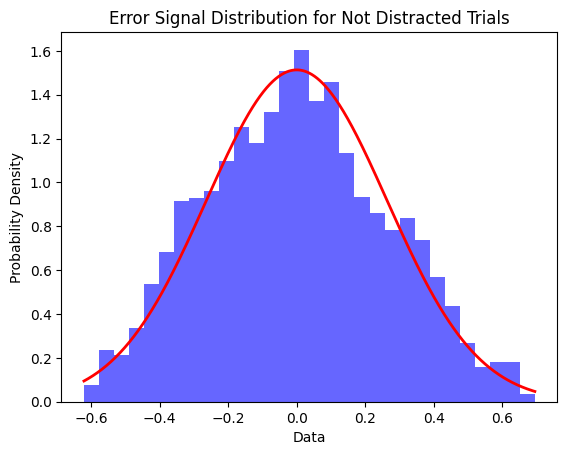

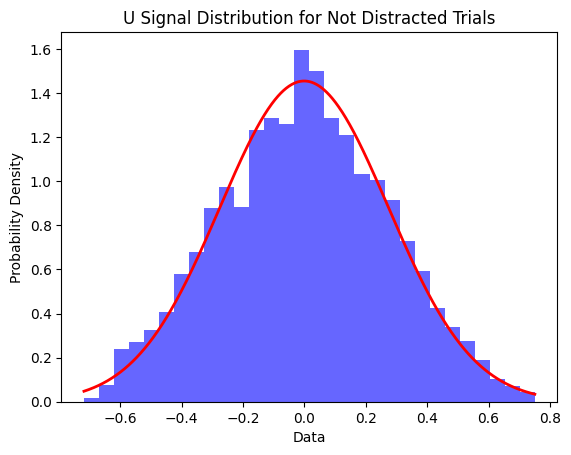

In [10]:
# combine the entire list in the priors
error_not_distracted = np.loadtxt(r'/home/mihai/Thesis/HumanSimulator/Simulated_signals/focused_error_signal.csv', delimiter=',')
u_not_distracted = np.loadtxt(r'/home/mihai/Thesis/HumanSimulator/Simulated_signals/focused_u.csv', delimiter=',')

# Fit a Gaussian to the error signal data
error_not_distracted_distribution = fit_gaussian(error_not_distracted)

# Plot the Gaussian on top of the histogram and KDE for distracted data
plot_gaussian_1d(error_not_distracted, error_not_distracted_distribution[0], error_not_distracted_distribution[1], color='red', title='Error Signal Distribution for Not Distracted Trials')

u_not_distracted_distribution = fit_gaussian(u_not_distracted)

# Plot the Gaussian on top of the histogram and KDE for distracted data
plot_gaussian_1d(u_not_distracted, u_not_distracted_distribution[0], u_not_distracted_distribution[1], color='red', title='U Signal Distribution for Not Distracted Trials')

## Read the signals to be tested

In [12]:
error_signal_test = np.loadtxt(r'/home/mihai/Thesis/HumanSimulator/Simulated_signals/test_error_signal.csv', delimiter=',')
tc_test = np.loadtxt(r'/home/mihai/Thesis/HumanSimulator/Simulated_signals/test_tc.csv', delimiter=',')
u_signal_test = np.loadtxt(r'/home/mihai/Thesis/HumanSimulator/Simulated_signals/test_u.csv', delimiter=',')

print(f"{error_signal_test.shape=}; {tc_test.shape=}; {u_signal_test.shape=}")    

error_signal_test.shape=(20000,); tc_test.shape=(20000,); u_signal_test.shape=(20000,)


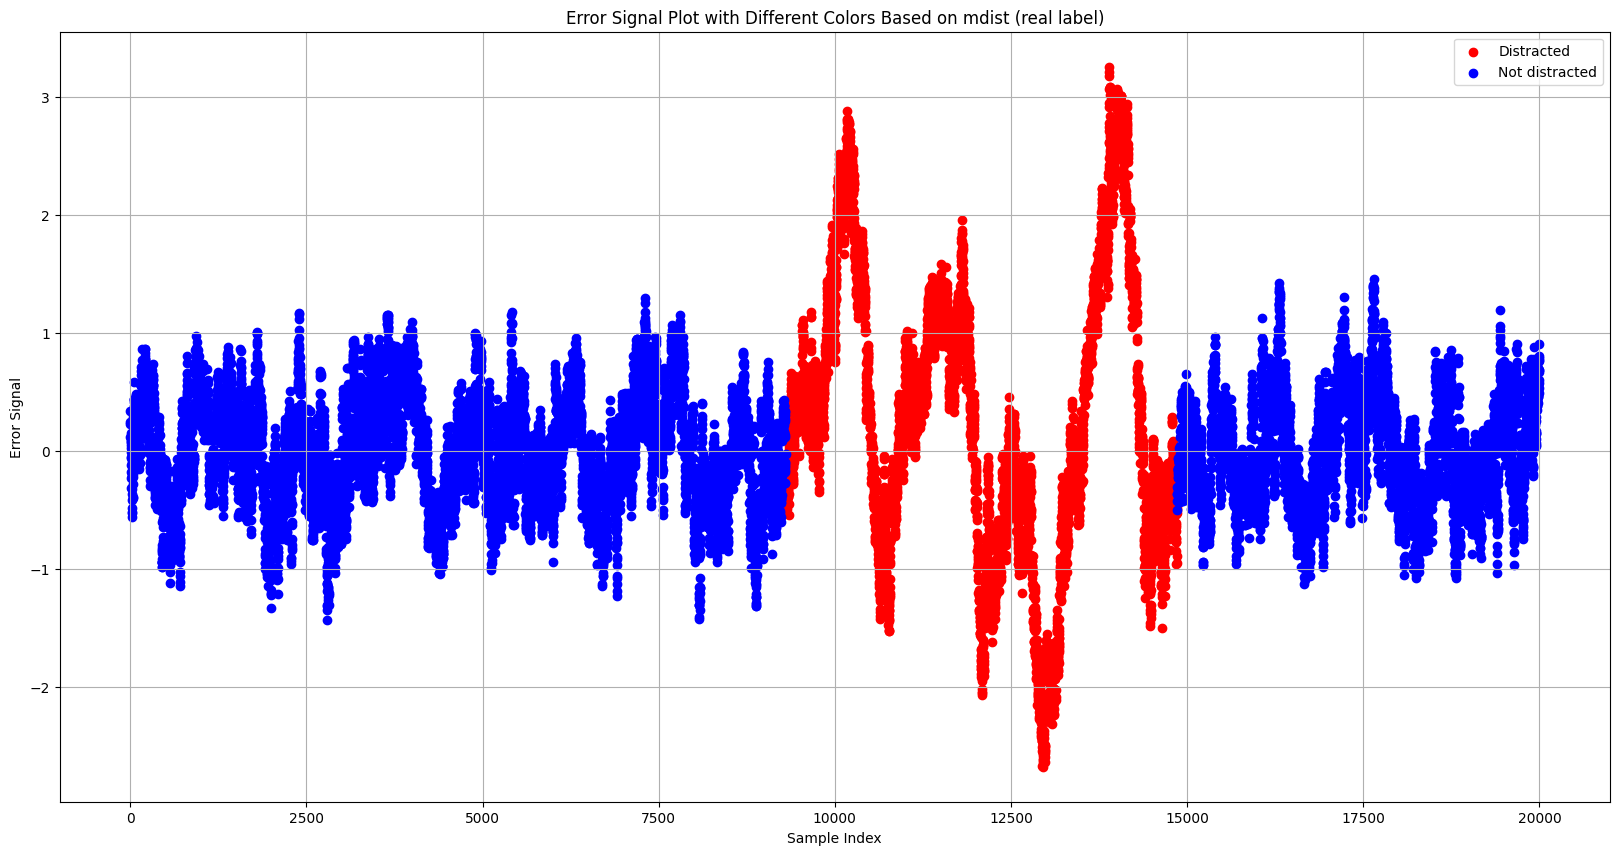

In [13]:

# Create a mask for tc_test == 1 and tc_test == 0
mask_1 = tc_test == 1
mask_0 = tc_test == 0

# Plotting
plt.figure(figsize=(20, 10))
plt.scatter(np.arange(len(error_signal_test))[mask_1], error_signal_test[mask_1], color='red', label='Distracted')
plt.scatter(np.arange(len(error_signal_test))[mask_0], error_signal_test[mask_0], color='blue', label='Not distracted')
plt.grid()
# Add labels and title
plt.xlabel('Sample Index')
plt.ylabel('Error Signal')
plt.title('Error Signal Plot with Different Colors Based on mdist (real label)')
plt.legend()
plt.show()

mean.shape=(2,); cov.shape=(2, 2)


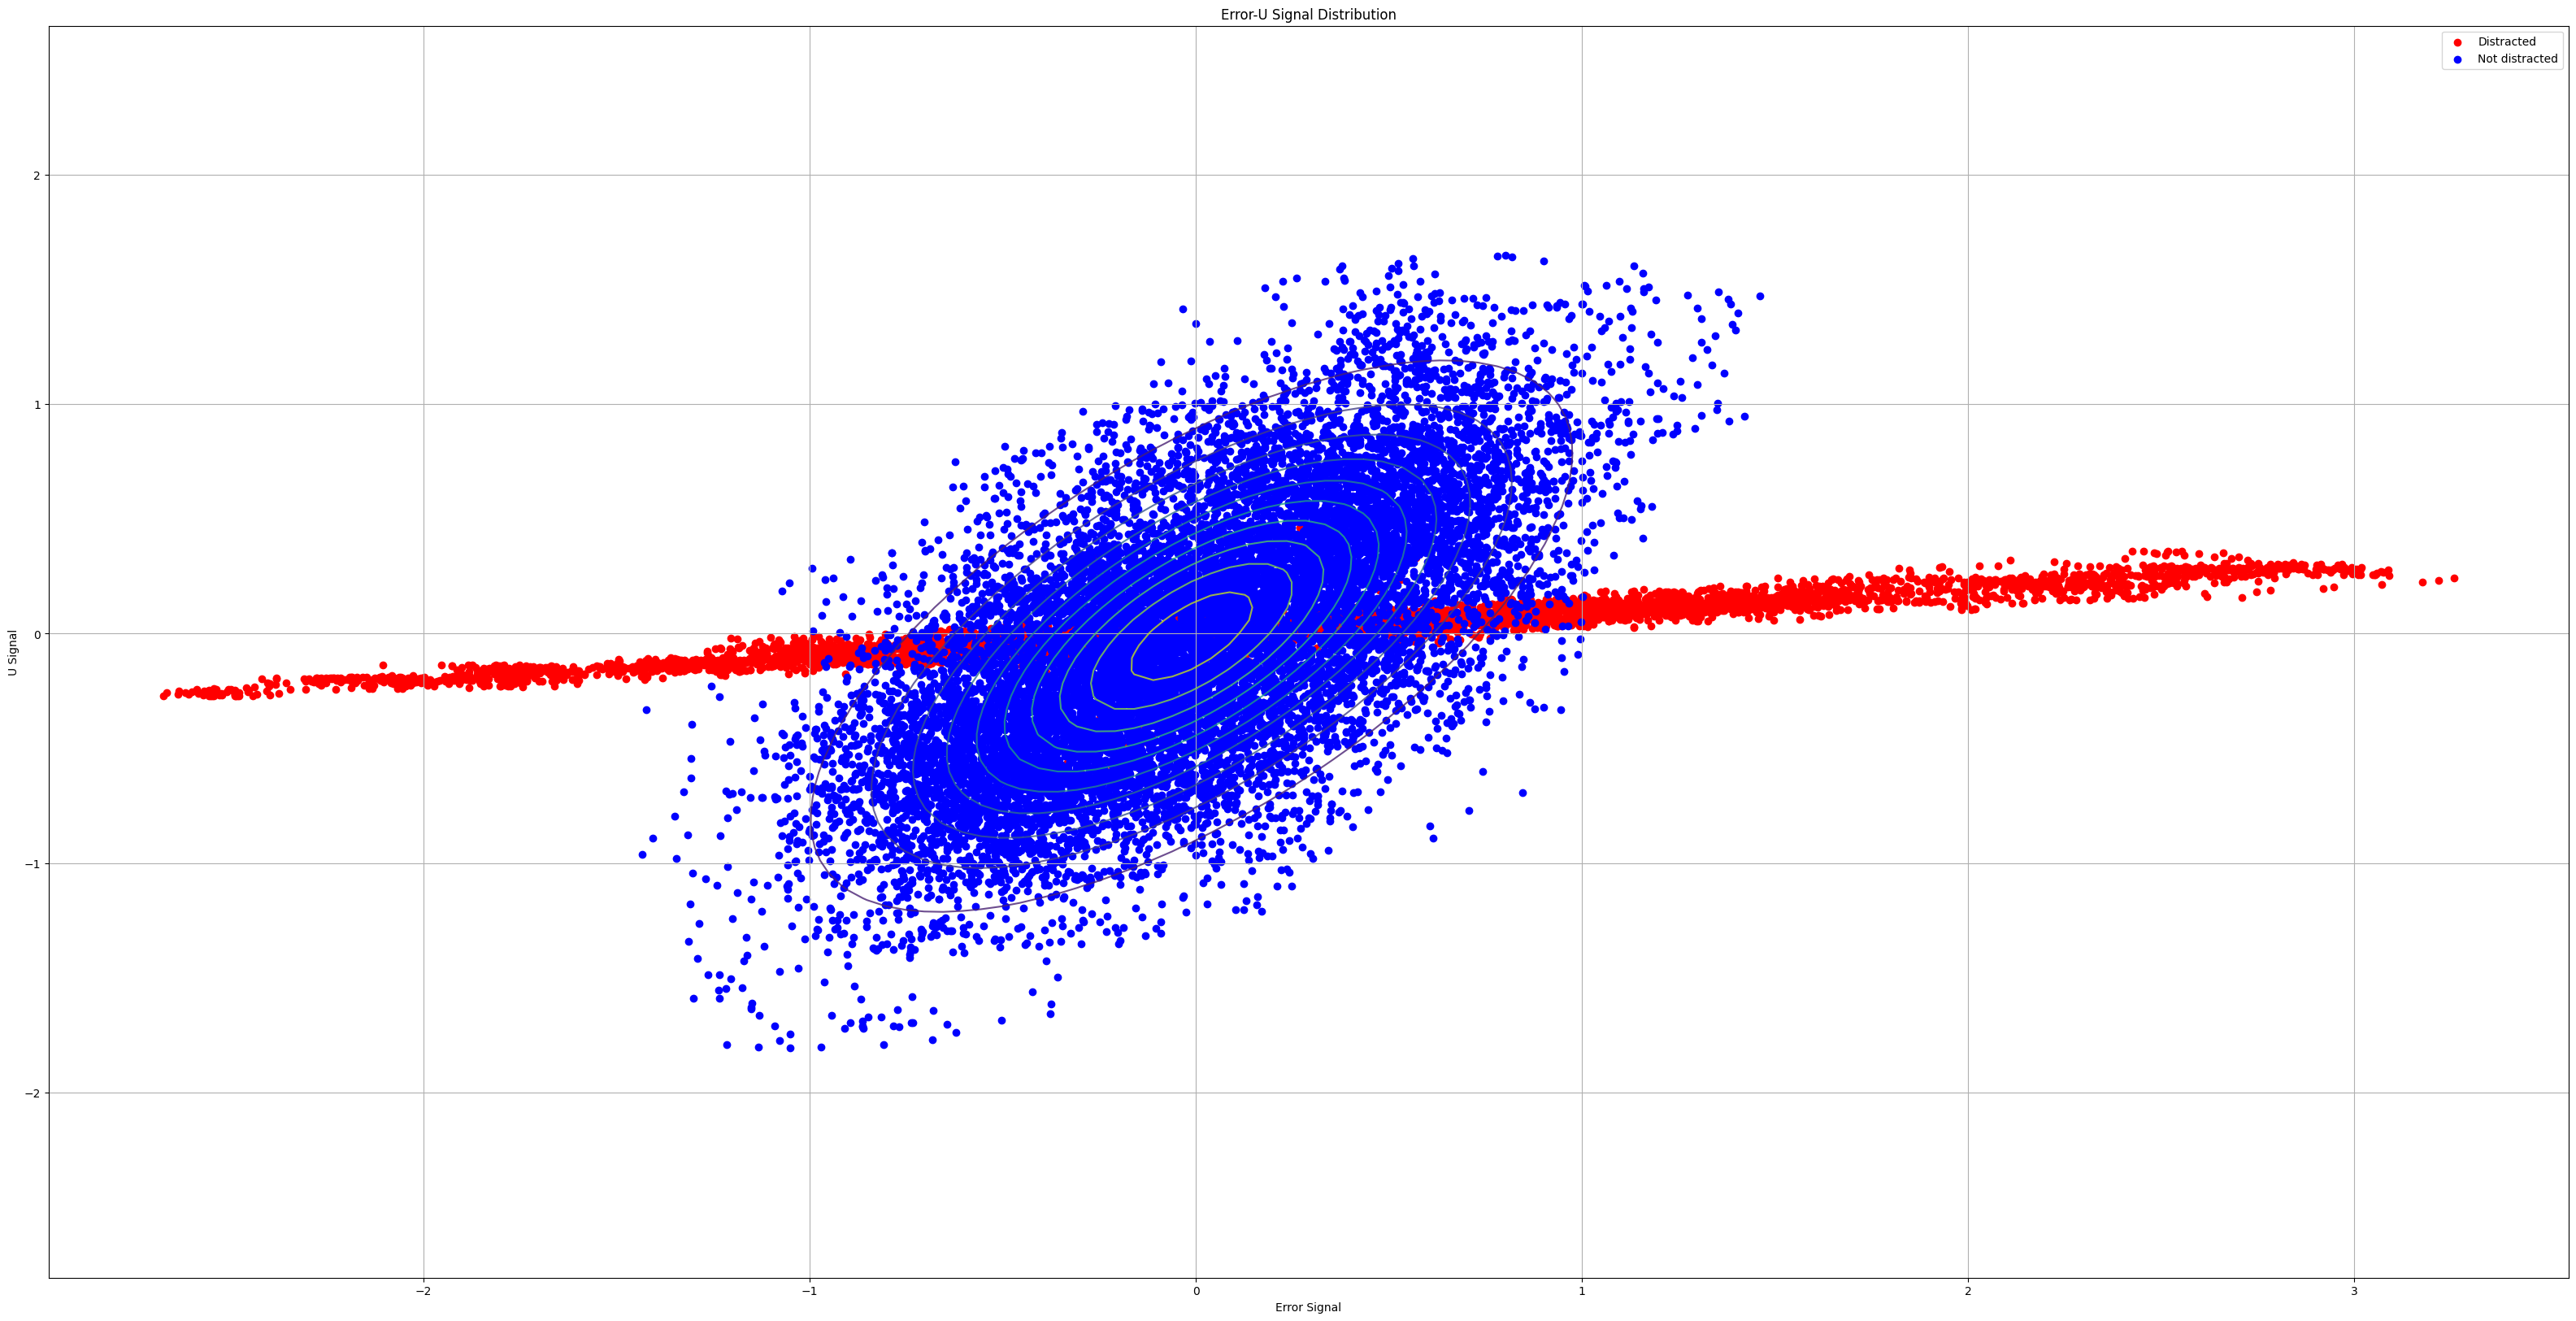

In [15]:
def plot_gaussian_2d(data, mean, cov, title='Gaussian 2D Plot'):
    """ Plot a 2D Gaussian distribution on top of the scatter plot.
    
    Args:
        data (numpy.ndarray): The input data used for fitting the Gaussian.
        mean (numpy.ndarray): The mean of the Gaussian.
        cov (numpy.ndarray): The covariance matrix of the Gaussian.
        title (str): The title of the plot.
    """
    # Create a grid of points
    x = np.linspace(np.min(data[:, 0]) - 1, np.max(data[:, 0]) + 1, 100)
    y = np.linspace(np.min(data[:, 1]) - 1, np.max(data[:, 1]) + 1, 100)
    X, Y = np.meshgrid(x, y)
    
    # Calculate the Gaussian PDF for each point on the grid
    pos = np.dstack((X, Y))
    Z = multivariate_normal.pdf(pos, mean=mean, cov=cov)
    
    # Plot the contour lines
    plt.contour(X, Y, Z, levels=10, cmap='viridis', alpha=0.8)
    plt.title(title)

# plot error signal and u signal in 2D
plt.figure(figsize=(40, 20))
plt.scatter(error_signal_test[mask_1], u_signal_test[mask_1], color='red', label='Distracted')
plt.scatter(error_signal_test[mask_0], u_signal_test[mask_0], color='blue', label='Not distracted')
plt.grid()
# Add labels and title
plt.xlabel('Error Signal')
plt.ylabel('U Signal')
plt.title('Error Signal vs U Signal Plot with Different Colors Based on mdist (real label)')
plt.legend()
# plt.show()

# fit and plot a 2d gaussian on top of the previous figure
# Fit a Gaussian to the error-u signal data
data = np.column_stack((error_signal_test[mask_0], u_signal_test[mask_0]))
mean, cov = fit_gaussian(data)
cov = np.cov(data, rowvar=False)

print(f"{mean.shape=}; {cov.shape=}")

# # plot the gaussian on top of the previous figure
plot_gaussian_2d(data, mean, cov, title='Error-U Signal Distribution')

points = np.column_stack((error_signal_test, u_signal_test))
arrows_mask = np.array(mask_0 | mask_1)

# Calculate the direction for arrows
dx = np.diff(points[arrows_mask, 0])
dy = np.diff(points[arrows_mask, 1])

# Start plotting arrows from each point, except the last one
arrow_start_x = points[arrows_mask][:-1, 0]
arrow_start_y = points[arrows_mask][:-1, 1]
# plt.quiver(arrow_start_x, arrow_start_y, dx, dy, color='green', angles='xy', scale_units='xy', scale=2, width=0.002)
plt.show()

## Test data 

In [36]:
data_test  = np.stack((error_signal_test, u_signal_test), axis=1)
input_not_distracted = np.column_stack((error_not_distracted, u_not_distracted))  # Non-distracted data
cov_input_not_distracted = np.cov(input_not_distracted, rowvar=False)

print(f"{cov_input_not_distracted}")
print(f"{cov}")

[[0.06951656 0.05479023]
 [0.05479023 0.07519907]]
[[0.20554326 0.16648515]
 [0.16648515 0.30504151]]


In [20]:
mean_not_distracted = np.mean(input_not_distracted, axis=0)
inv_cov_input_not_distracted = sp.linalg.inv(cov_input_not_distracted)
prior_not_distracted_pdf = multivariate_normal(mean = np.mean(input_not_distracted, axis=0), cov = cov_input_not_distracted)

tc_test_person = tc_test
data_test_person = data_test

print(f"{mean_not_distracted}")
print(f"{inv_cov_input_not_distracted}")

distances_from_prior = [distance.mahalanobis(sample, mean_not_distracted, inv_cov_input_not_distracted) for sample in data_test_person]
distance_other = np.loadtxt(r"/home/mihai/Thesis/distances_0_0.csv", delimiter=',')

[-0.00012377 -0.00072625]
[[ 33.78805801 -24.61806423]
 [-24.61806423  31.23482089]]


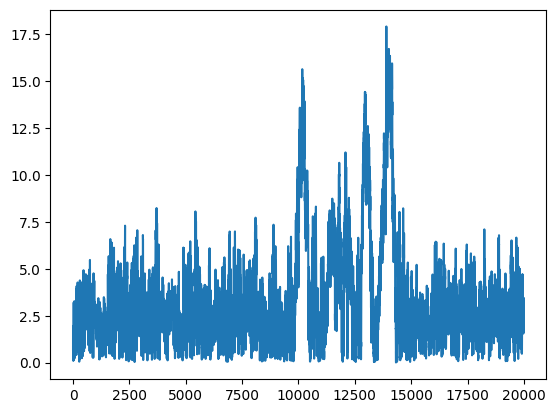

In [37]:
plt.plot(distances_from_prior, label='Mahalanobis distance from prior')

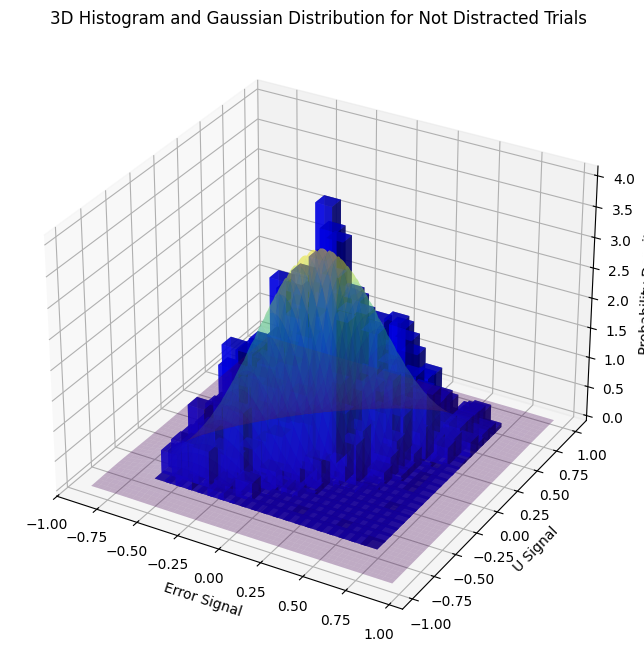

In [22]:
def plot_gaussian_3d(ax, mean, cov, x_range, y_range, title='Gaussian 3D Plot'):
    """ Plot a 3D Gaussian distribution.
    
    Args:
        ax: The 3D axis to plot on.
        mean (numpy.ndarray): Mean of the Gaussian.
        cov (numpy.ndarray): Covariance matrix of the Gaussian.
        x_range (tuple): Range for the x-axis.
        y_range (tuple): Range for the y-axis.
        title (str): Title of the plot.
    """
    x = np.linspace(x_range[0]-0.25, x_range[1]+0.25, 200)
    y = np.linspace(y_range[0]-0.25, y_range[1]+0.25, 200)
    X, Y = np.meshgrid(x, y)
    
    pos = np.dstack((X, Y))
    Z = multivariate_normal.pdf(pos, mean=mean, cov=cov)

    # Plot the surface
    ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.3)


# Create a 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Define the ranges for the Gaussian plot
x_range = (np.min(error_not_distracted), np.max(error_not_distracted))
y_range = (np.min(u_not_distracted), np.max(u_not_distracted))

# Create the 3D histogram
hist, xedges, yedges = np.histogram2d(error_not_distracted, u_not_distracted, bins=20, density=True)

# Construct arrays for the anchor positions of the bars.
xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1], indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0  # Start all bars from z=0

# Construct arrays with the dimensions for the bars.
dx = dy = 0.1 * np.ones_like(zpos)  # Width of the bars
dz = hist.ravel()  # Height of the bars (frequency)

# Create the 3D bar plot
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average', alpha=0.7, color='blue')

# Plot the Gaussian surface
plot_gaussian_3d(ax, mean_not_distracted, cov_input_not_distracted, x_range, y_range)

# Add labels and title
ax.set_xlabel('Error Signal')
ax.set_ylabel('U Signal')
ax.set_zlabel('Probability Density')
ax.set_title('3D Histogram and Gaussian Distribution for Not Distracted Trials')

plt.show()

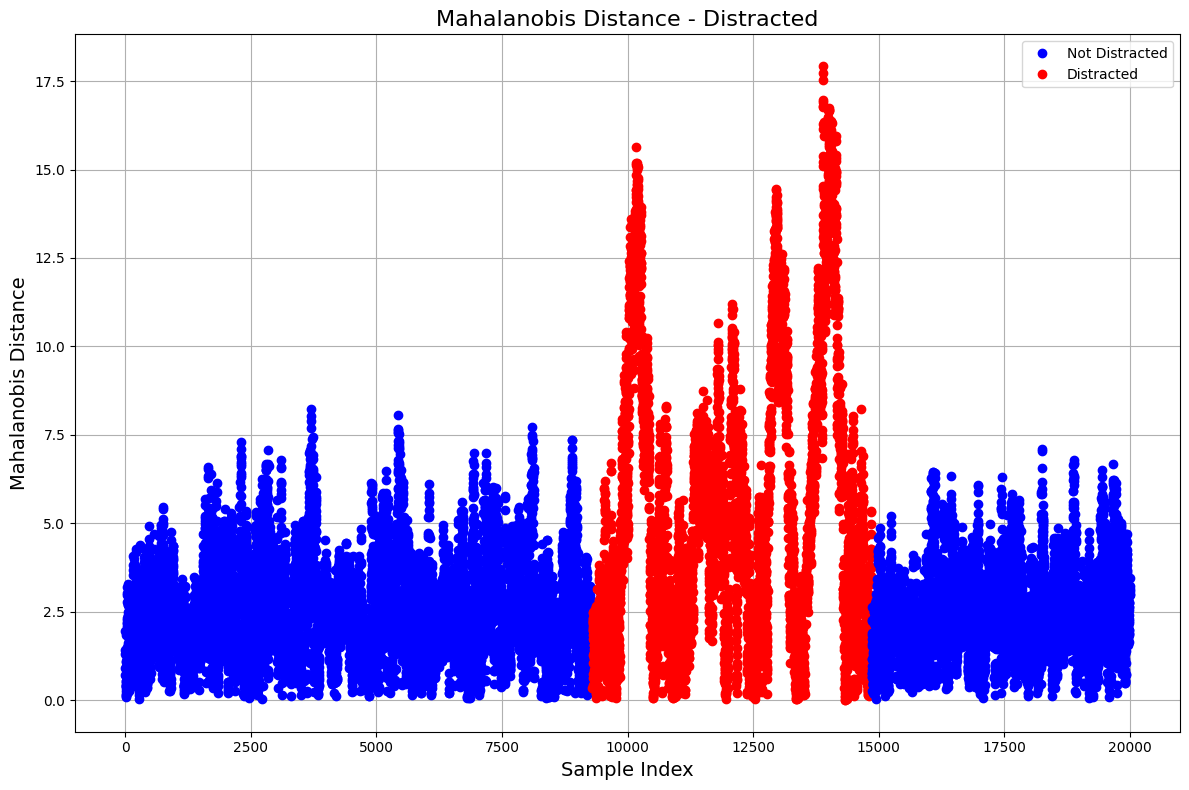

In [23]:
# Set up a larger single plot
fig, ax1 = plt.subplots(1, 1, figsize=(12, 8))  # Larger figure size for a single plot

# Create lists to keep track of plots for legend
distract_legend_plots = []
not_distract_legend_plots = []

#  Plot Mahalanobis distance values for distracted data
for i, (pdf_value, tc_value) in enumerate(zip(distances_from_prior, tc_test_person)):
    color = 'b' if tc_value == 0 else 'r'  # Color coding: blue for 'not distracted', red for 'distracted'
    plot = ax1.plot(i, pdf_value, marker='o', linestyle='', color=color)
    
    # Add plot for legend (only once per color)
    if tc_value == 0 and not distract_legend_plots:
        distract_legend_plots.append(plot[0])
    elif tc_value == 1 and len(distract_legend_plots) < 2:
        distract_legend_plots.append(plot[0])

# Set titles and labels for the plot
ax1.set_title("Mahalanobis Distance - Distracted", fontsize=16)
ax1.set_xlabel("Sample Index", fontsize=14)
ax1.set_ylabel("Mahalanobis Distance", fontsize=14)
ax1.grid(True)

# Adding a legend
ax1.legend(distract_legend_plots, ['Not Distracted', 'Distracted'], loc='best')

# Show the plot
plt.tight_layout()
plt.show()

## Plot the time traces

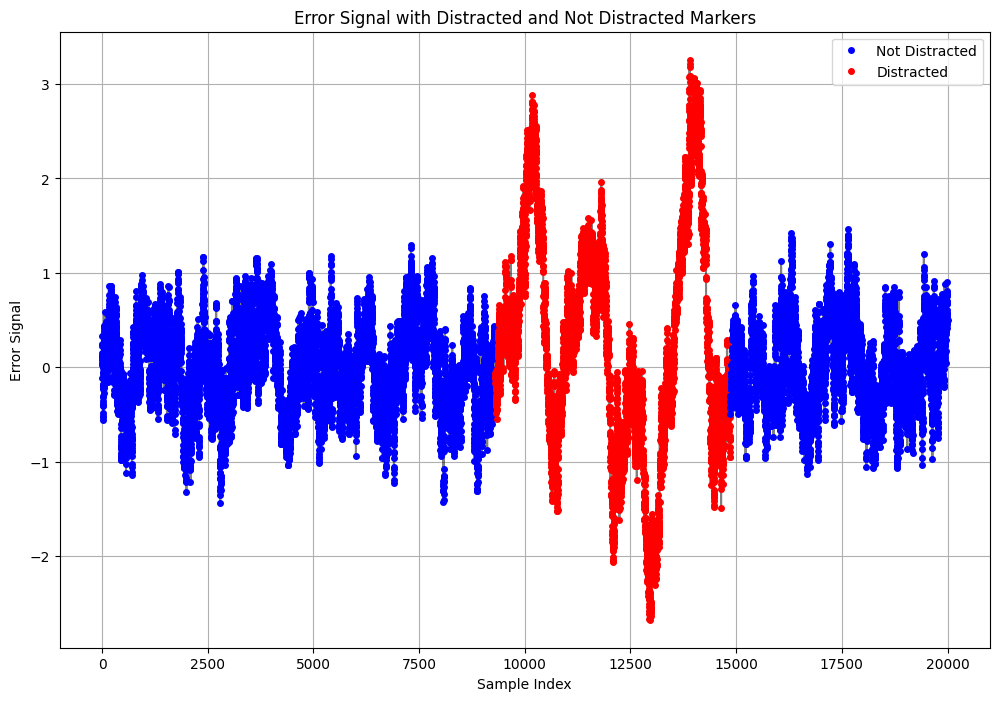

In [25]:
# Create a larger figure
fig, ax2 = plt.subplots(figsize=(12, 8))  # Increase the size of the figure

# Plot the error signal for the first column with reduced line width and alpha for visibility
ax2.plot(error_signal_test, label="Error Signal", color='k', alpha=0.5)

# Initialize lists to handle the legend plots
not_distract_legend_plots = []

# Iterate through the distances and tc labels
for i, (pdf_value, tc_value) in enumerate(zip(error_signal_test, tc_test_person)):
    # Set color based on tc_value
    color = 'b' if tc_value == 0 else 'r'
    # Plot each point with smaller marker size
    plot = ax2.plot(i, pdf_value, marker='o', linestyle='', color=color, markersize=4)  # Reduce marker size

    # Add to legend only once for each class (0 and 1)
    if tc_value == 0 and not not_distract_legend_plots:
        not_distract_legend_plots.append(plot[0])
    elif tc_value == 1 and len(not_distract_legend_plots) == 1:
        not_distract_legend_plots.append(plot[0])

# Add the legend to indicate the meaning of the colors
ax2.legend(not_distract_legend_plots, ['Not Distracted', 'Distracted'], loc='best')

# Add grid and labels
plt.grid(True)
ax2.set_xlabel("Sample Index")
ax2.set_ylabel("Error Signal")
ax2.set_title("Error Signal with Distracted and Not Distracted Markers")

# Show the plot
plt.show()


## Detect distraction based on Mahalanobis distance

## Here the decision making mechanism is implemented
For now, there would be several ideas to be tested:
1. Trigger distraction alarm every time the things steps out of the "safe area"
2. Trigger distraction alarm after a number of consecutice thresholds spent outside the "safe area"
3. Trigger distraction when evidence accumulated against the Null hypothesis "not distracted"
4. Incorporate momentum, i.e. mahalanobis distance derivative
5. Use exponential weighted window

??? Now, we should also compare these methods somehow ???

In [26]:
def detect_distractions_mahalanobis_old(data_test_column, mean_not_distracted, inv_cov_input_not_distracted, n_consecutive_threshold=10):
    # Compute Mahalanobis distances for the test samples against the distracted distribution
    distances_distracted = [distance.mahalanobis(sample, mean_not_distracted, inv_cov_input_not_distracted) for sample in data_test_column]

    # Calculate the chi-squared thresholds based on 80% and 75% confidence and the dimensionality of the data
    threshold_distracted = chi2.ppf(0.8, mean_not_distracted.shape[0])  # Threshold for distraction
    threshold_reset = chi2.ppf(0.75, mean_not_distracted.shape[0])       # Threshold to resume search
    print(f"Chi-squared distraction threshold (0.70): {threshold_distracted}")
    print(f"Chi-squared reset threshold (0.75): {threshold_reset}")
    
    # Detect distractions by checking whether the Mahalanobis distance exceeds the 80% threshold
    detected_distracted = np.array(distances_distracted) > threshold_distracted

    # Initialize variables to keep track of consecutive exceedances and distraction reset mechanism
    consecutive_count = 0
    distractions_detected = []  # This will store the timestamps where distractions were detected
    distraction_active = False  # Whether distraction detection is currently paused

    # Loop through the detected_distracted array to find consecutive distractions
    for i, (is_distracted, distance_value) in enumerate(zip(detected_distracted, distances_distracted)):
        if distraction_active:
            # If we're in distraction mode, wait until the distance falls below the reset threshold
            if distance_value < threshold_reset:
                consecutive_count = 0  # Reset the counter once we detect a "non-distracted" sample below the reset threshold
                distraction_active = False  # Resume checking distractions after returning below reset threshold
            continue  # Skip further checks until distraction ends
        
        if is_distracted:
            consecutive_count += 1  # Increment the counter if a distraction is detected
        else:
            consecutive_count = 0  # Reset the counter if a distraction is not detected
        
        # If the number of consecutive distractions reaches the threshold, log the distraction
        if consecutive_count == n_consecutive_threshold:
            distractions_detected.append(i)  # Store the time (or index) of the threshold-reaching distraction
            consecutive_count = 0  # Reset the counter after detecting a distraction
            distraction_active = True  # Pause detection until behavior falls below reset threshold
    
    return distractions_detected, detected_distracted, distances_distracted

def detect_distractions_mahalanobis(data_test_column, mean_not_distracted, inv_cov_input_not_distracted, h=2):
    # Compute Mahalanobis distances for the test samples against the distracted distribution
    distances_distracted = [distance.mahalanobis(sample, mean_not_distracted, inv_cov_input_not_distracted) for sample in data_test_column]

    # Calculate the chi-squared thresholds based on 80% and 75% confidence and the dimensionality of the data
    threshold_distracted = chi2.ppf(0.8, mean_not_distracted.shape[0])  # Threshold for distraction
    threshold_reset = chi2.ppf(0.75, mean_not_distracted.shape[0])      # Threshold to resume search
    print(f"Chi-squared distraction threshold (0.80): {threshold_distracted}")
    print(f"Chi-squared reset threshold (0.75): {threshold_reset}")
    
    # Initialize variables for CUSUM
    S_pos = 0  # Positive cumulative sum (for upward shifts, i.e., distraction)
    distractions_detected = []  # List to store timestamps of detected distractions
    distraction_active = False  # Whether distraction detection is currently paused
    S_pos_list = [S_pos]  # List to store the cumulative sum values for visualization
    # Loop through Mahalanobis distances and apply CUSUM logic
    for i, distance_value in enumerate(distances_distracted):
        if distraction_active:
            # If distraction mode is active, wait until the distance falls below the reset threshold
            if distance_value < threshold_reset:
                S_pos = 0  # Reset the cumulative sum after normal behavior
                distraction_active = False  # Resume checking distractions
            continue  # Skip further checks while in distraction mode

        # If the Mahalanobis distance exceeds the distraction threshold, accumulate the difference in S_pos
        if distance_value > threshold_distracted:
            S_pos += distance_value - threshold_distracted
        else:
            S_pos = 0  # Reset S_pos if the distance does not exceed the threshold

        # If S_pos exceeds the threshold h, activate distraction mode
        if S_pos > h:
            distractions_detected.append(i)  # Log the index where distraction is detected
            distraction_active = True  # Activate distraction mode
            S_pos = 0  # Reset cumulative sum to prepare for next detection
        S_pos_list.append(S_pos)
    return distractions_detected, S_pos_list, distances_distracted

In [30]:
def detect_distractions_mahalanobis_aux(tc_test, data_test, mean_not_distracted, inv_cov_input_not_distracted):
    column_index = 8
    num_columns = 1  # Get the number of columns
    # for column_index in range(num_columns):
    tc_test_column = tc_test
    data_test_column = data_test
    distractions_detected, detected_distracted, distances_distracted = detect_distractions_mahalanobis(data_test_column, mean_not_distracted, inv_cov_input_not_distracted)
    
    return distractions_detected, detected_distracted, distances_distracted, tc_test_column
        # compute some performance metrics
        

distractions_detected, detected_distracted, distances_distracted, tc_test_column = detect_distractions_mahalanobis_aux(tc_test, data_test, mean_not_distracted, inv_cov_input_not_distracted)

Chi-squared distraction threshold (0.80): 3.218875824868201
Chi-squared reset threshold (0.75): 2.772588722239781


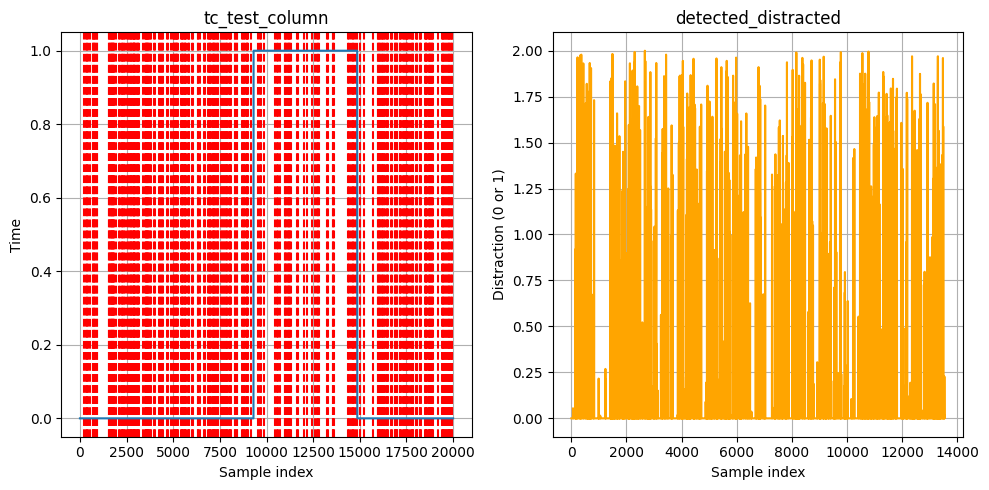

In [31]:
# Plotting the two side by side
plt.figure(figsize=(10, 5))

# Plot tc_test_column
plt.subplot(1, 2, 1)
# add as vertical lines the detected distractions
for i in range(len(distractions_detected)):
    plt.axvline(x=distractions_detected[i], color='red', linestyle='--')
plt.grid()
plt.plot(tc_test_column, label="tc_test_column")
plt.title("tc_test_column")
plt.xlabel("Sample index")
plt.ylabel("Time")

# Plot detected_distracted
plt.subplot(1, 2, 2)
plt.grid()
plt.plot(detected_distracted, label="detected_distracted", color='orange')
plt.title("detected_distracted")
plt.xlabel("Sample index")
plt.ylabel("Distraction (0 or 1)")

plt.tight_layout()
plt.show()

## For the performance metric calculation:
1. if there is a indeed distracted behaviour during the alarm being triggered, count as a good detection
2. no distracted samples around the alarm being triggered ==> consider it false alarm
3. if the person is distracted for 1 second without the alarm being triggered ==> count it as a missed detection
